In [1]:
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import os

In [17]:
files = glob.glob("darknet/backup/*.map")
files.sort(key=os.path.getmtime)
print(len(files))
files

20


['darknet/backup/yolov3-tiny-signals_1000.map',
 'darknet/backup/yolov3-tiny-signals_2000.map',
 'darknet/backup/yolov3-tiny-signals_3000.map',
 'darknet/backup/yolov3-tiny-signals_4000.map',
 'darknet/backup/yolov3-tiny-signals_5000.map',
 'darknet/backup/yolov3-tiny-signals_6000.map',
 'darknet/backup/yolov3-tiny-signals_7000.map',
 'darknet/backup/yolov3-tiny-signals_8000.map',
 'darknet/backup/yolov3-tiny-signals_9000.map',
 'darknet/backup/yolov3-tiny-signals_10000.map',
 'darknet/backup/yolov3-tiny-signals_11000.map',
 'darknet/backup/yolov3-tiny-signals_12000.map',
 'darknet/backup/yolov3-tiny-signals_13000.map',
 'darknet/backup/yolov3-tiny-signals_14000.map',
 'darknet/backup/yolov3-tiny-signals_15000.map',
 'darknet/backup/yolov3-tiny-signals_16000.map',
 'darknet/backup/yolov3-tiny-signals_17000.map',
 'darknet/backup/yolov3-tiny-signals_18000.map',
 'darknet/backup/yolov3-tiny-signals_19000.map',
 'darknet/backup/yolov3-tiny-signals_20000.map']

In [6]:
class signal:
    def __init__(self, name, ap, TP, FP):
        self.name = name
        self.ap = ap
        self.TP = TP
        self.FP = FP
    
    def printstats(self):
        print("Signal [ name:{}, average precision:{}%, true positives:{}, false positives:{} ]".format(self.name, self.ap, self.TP, self.FP))
    
class signal_summary:
    def __init__(self, TP, FP, FN, average_iou, mean_ap):
        self.TP = TP
        self.FP = FP
        self.FN = FN
        self.average_iou = average_iou
        self.mean_ap = mean_ap   
        
    def printstats(self):
        print("Summary [ true positives:{}, false positives:{}, false negatives:{}, average IoU:{}%, mean average precision (mAP):{}% ]".format(self.TP, self.FP, self.FN, self.average_iou, self.mean_ap))

In [7]:
def addSignalToDictionary(dictionary, key, value):
    if key in dictionary:
        dictionary[str(key)] = np.append(dictionary[str(key)], value)
    else:
        dictionary[str(key)] = np.array([value])
    

In [28]:
signal_stat = {}

for file in files:
    with open(file, "r") as openfile:
        summary = signal_summary(0,0,0,0,0)
        for line in openfile:
            
            # get single signal data
            if line.startswith("class_id"):
                result_name = re.search("name = .*, ap", line)
                result_ap = re.search("ap = .*%", line)
                result_tp = re.search("TP = .*,", line)
                result_fp = re.search("FP = .*\)", line)

                if result_name is not None and result_ap is not None and result_tp is not None and result_fp is not None:
                    name = result_name.group().replace(", ap","").replace("name = ","")
                    ap = result_ap.group().replace("ap = ","").replace("%","")
                    tp = result_tp.group().replace("TP = ","").replace(",","")
                    fp = result_fp.group().replace("FP = ","").replace(")","")
                    new_signal = signal(name, ap, tp, fp)
                    #new.printstats()
                    addSignalToDictionary(signal_stat, name, new_signal)
                continue
                    
            # get summary
            if line.startswith(" for conf_thresh"):
                result_tp = re.search("TP = .*, FP", line)
                result_fp = re.search("FP = .*, FN", line)
                result_fn = re.search("FN = .*,", line)
                result_iou = re.search("average IoU = .* %", line)
                
                if result_tp is not None and result_fp is not None and result_fn is not None and result_iou is not None:                    
                    summary.TP = result_tp.group().replace("TP = ","").replace(", FP","")
                    summary.FP = result_fp.group().replace("FP = ","").replace(", FN","")
                    summary.FN = result_fn.group().replace("FN = ","").replace(",","")
                    summary.average_iou = result_iou.group().replace("average IoU = ","").replace(" %","")
                continue
                
            # get mean average precision
            if line.startswith(" mean average"):
                result_map = re.search(", or .* %", line)
                if result_map is not None:
                    summary.mean_ap = result_map.group().replace(", or ", "").replace(" %", "")
                    #summary.printstats()
                    addSignalToDictionary(signal_stat, "summary", summary)
                continue


len(signal_stat)
    

11

In [29]:
len(signal_stat["signal 1"])

20

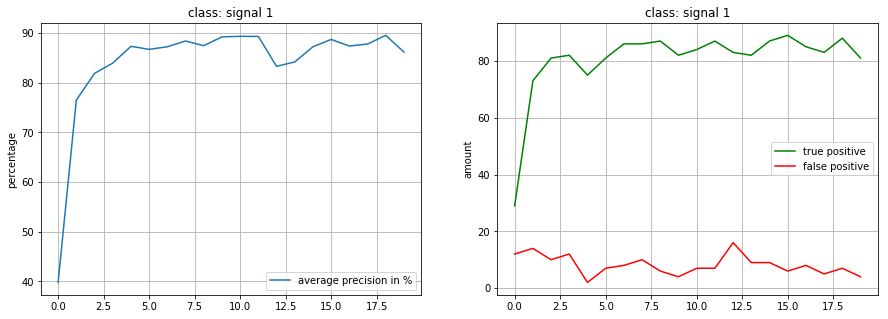

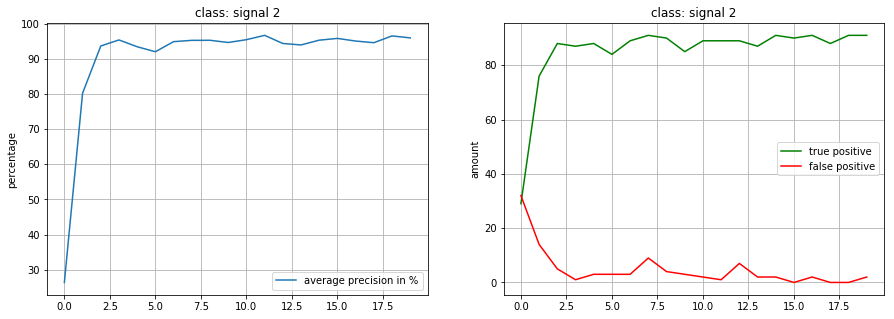

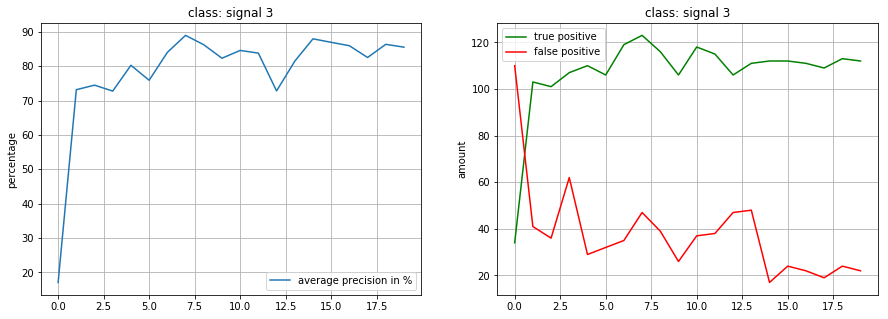

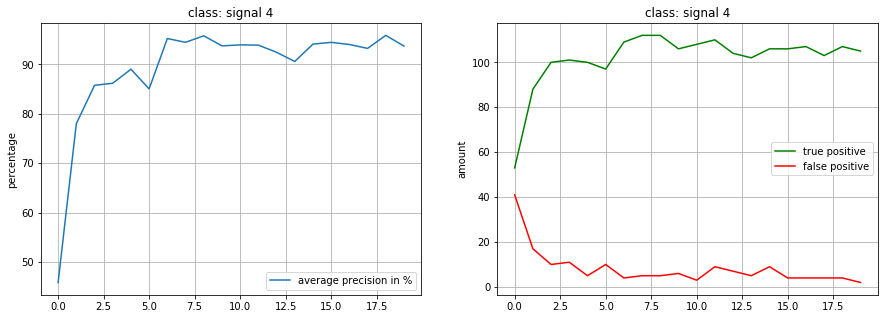

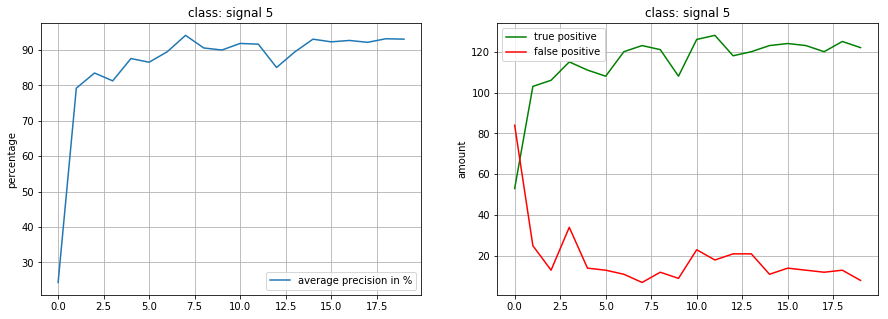

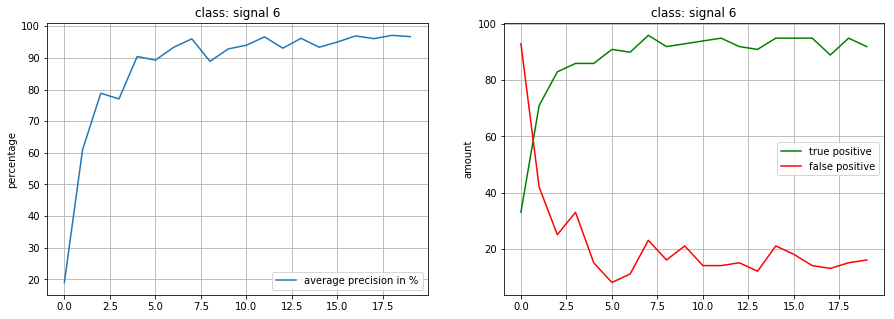

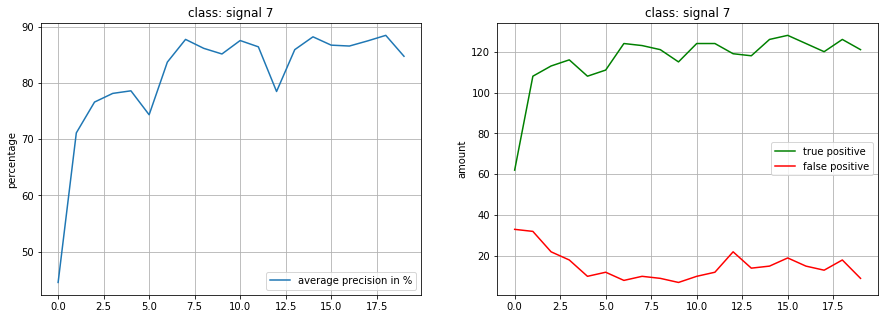

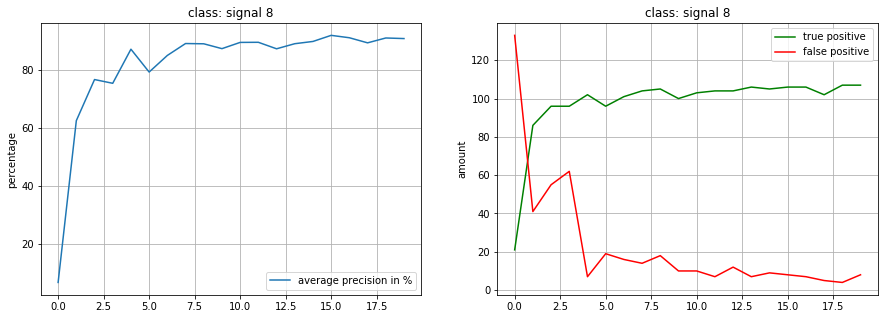

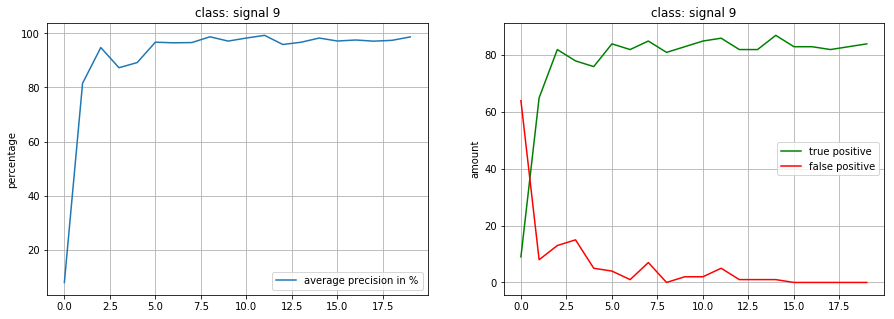

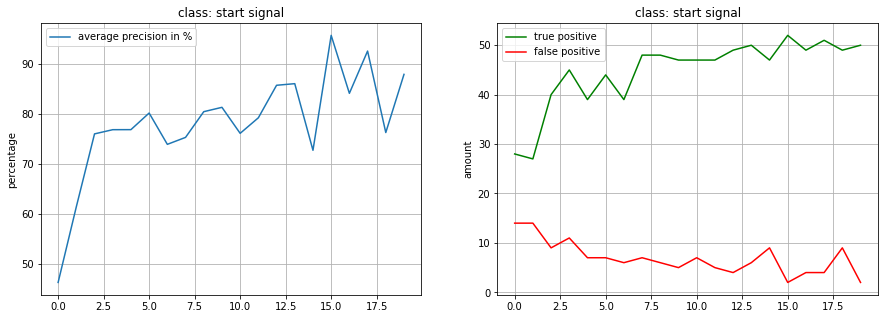

In [30]:
graph_dir = "graphs/"
if not os.path.exists(graph_dir):
    os.makedirs(graph_dir)

for key in signal_stat.keys():
    if key is not "summary":
        ap = [float(signal.ap) for signal in signal_stat[key]]
        tp = [int(signal.TP) for signal in signal_stat[key]]
        fp = [int(signal.FP) for signal in signal_stat[key]]

        plt.figure(figsize=(15,5))
        plt.subplot(121, title="class: "+key, ylabel="percentage")
        plt.plot(ap, label="average precision in %")
        plt.legend()
        plt.grid(True)

        plt.subplot(122, title="class: "+key, ylabel="amount")
        plt.plot(tp, "g", label="true positive")
        plt.plot(fp, "r", label="false positive")
        plt.legend()
        plt.grid(True)
        plt.savefig("graphs/"+key+".png")
        plt.show()


[23.6, 53.05, 59.5, 57.58, 68.5, 66.1, 66.17, 66.37, 67.51, 69.3, 68.08, 68.83, 64.77, 67.88, 69.49, 69.87, 71.86, 73.1, 72.07, 73.44]


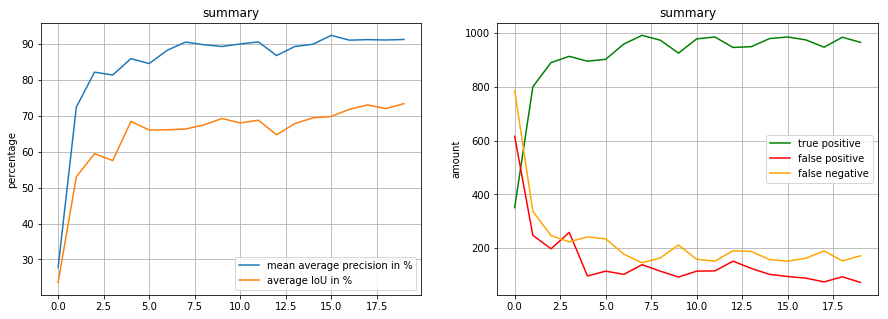

In [64]:
key = "summary"
tp = [float(signal.TP) for signal in signal_stat[key]]
fp = [int(signal.FP) for signal in signal_stat[key]]
fn = [int(signal.FN) for signal in signal_stat[key]]
average_iou = [float(signal.average_iou) for signal in signal_stat[key]]
mean_ap = [float(signal.mean_ap) for signal in signal_stat[key]]
print(average_iou)

plt.figure(figsize=(15,5))
plt.xlim(0,110)
plt.subplot(121, title=key, ylabel="percentage")
plt.plot(mean_ap, label="mean average precision in %")
plt.plot(average_iou, label="average IoU in %")
plt.legend()

plt.grid(True)

plt.subplot(122, title=key, ylabel="amount")
plt.plot(tp, "g", label="true positive")
plt.plot(fp, "r", label="false positive")
plt.plot(fn, "orange", label="false negative")
plt.legend()
plt.grid(True)
plt.savefig("graphs/"+key+".png")
plt.show()

In [65]:
i = 0
highest = None
highest_i = 0
best_signal = None
for x in signal_stat["summary"]:
    #print(i, x.mean_ap, x.TP, x.FP, x.FN)
    check_val = float(x.mean_ap) - (float(x.FP) + float(x.FN))
    if highest == None or highest < check_val:
        highest = check_val
        highest_i = i
        best_signal = x
    i = i + 1

print("Best iteration was number:", highest_i)
print("which is file: ", files[highest_i])

Best iteration was number: 19
which is file:  darknet/backup/yolov3-tiny-signals_20000.map


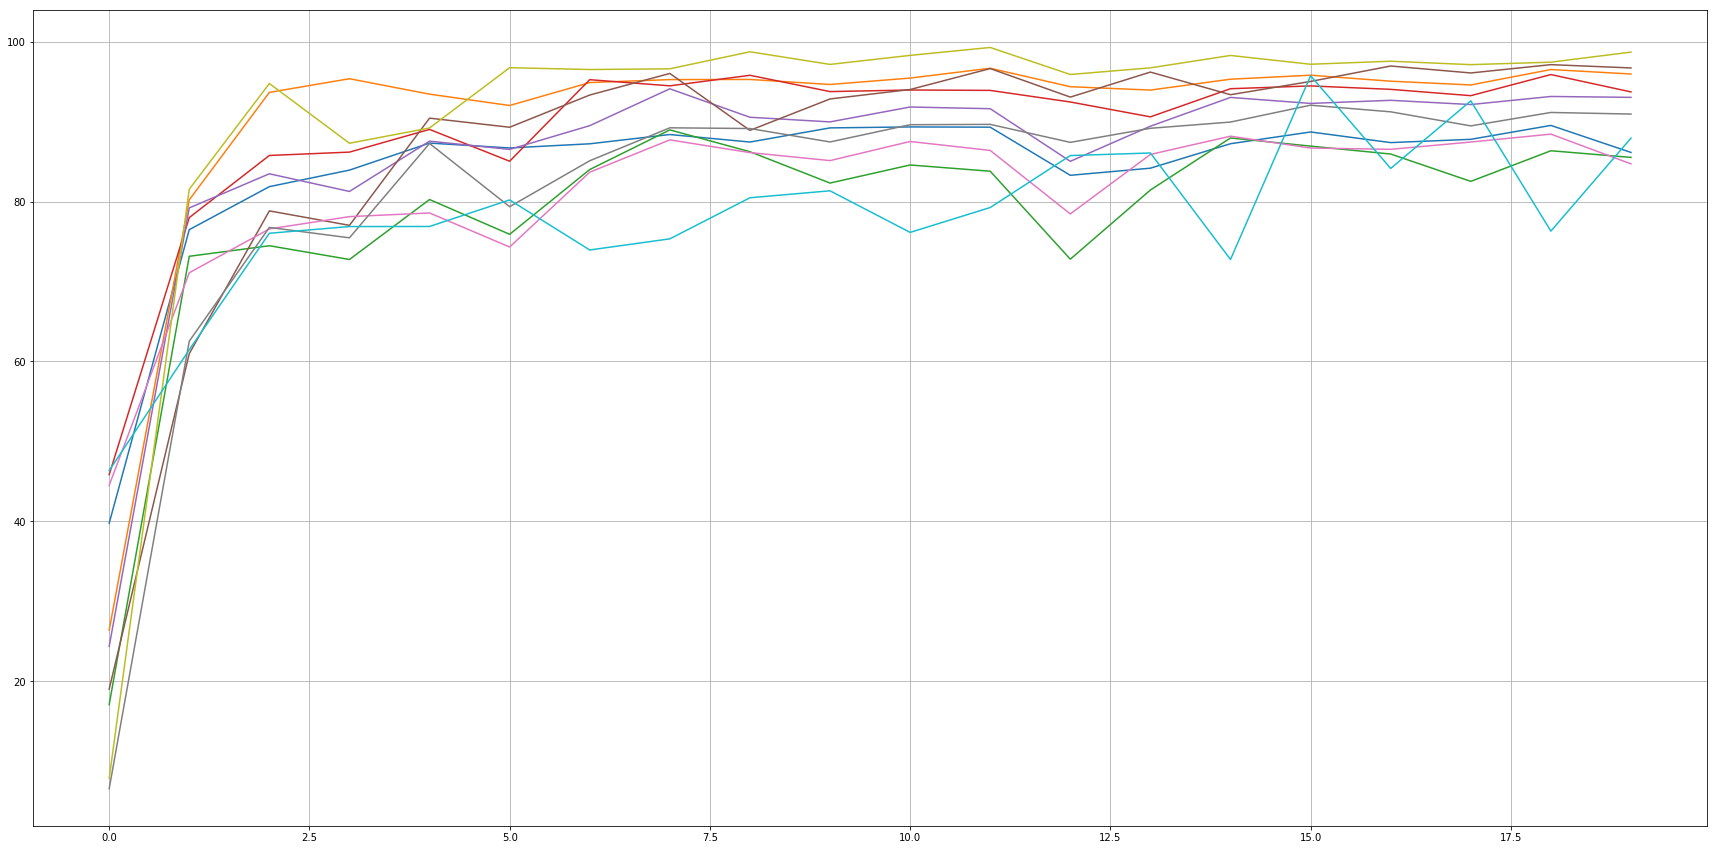

In [62]:
plt.figure(figsize=(30,15))
plt.grid(True)
for key in signal_stat.keys():
    if key is not "summary":
        ap = [float(signal.ap) for signal in signal_stat[key]]
        plt.plot(ap, label="average precision in %")
        
plt.show()